## Load Dataset

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score
files = ['Datasets\Aggregation.txt', 'Datasets\D31.txt', 'Datasets\R15.txt']
df = [pd.read_csv(file, header=None, sep=" ") for file in files]
for i in range(len(df)):
    print(df[i].head())

       0      1
0  15.55  28.65
1  14.90  27.55
2  14.45  28.35
3  14.15  28.80
4  13.75  28.05
         0       1
0  25.0514  5.7475
1  26.6614  7.3414
2  25.2653  6.2466
3  25.2285  4.7447
4  25.7529  5.1564
        0       1
0   9.802  10.132
1  10.350   9.768
2  10.098   9.988
3   9.730   9.910
4   9.754  10.430


## Dataset Info

In [15]:
for i in range(len(df)):
    print(df[i].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 0 to 787
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       788 non-null    float64
 1   1       788 non-null    float64
dtypes: float64(2)
memory usage: 12.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3100 entries, 0 to 3099
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3100 non-null   float64
 1   1       3100 non-null   float64
dtypes: float64(2)
memory usage: 48.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       600 non-null    float64
 1   1       600 non-null    float64
dtypes: float64(2)
memory usage: 9.5 KB
None


## Data process

In [16]:
# 归一化
array = [np.array(dfi.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))) for dfi in df]
for i in range(len(df)):
    print(array[i])

[[0.36746988 0.98161765]
 [0.34789157 0.94117647]
 [0.33433735 0.97058824]
 ...
 [0.15512048 0.04779412]
 [0.14307229 0.05882353]
 [0.14457831 0.07536765]]
[[0.8297854  0.07501544]
 [0.89011463 0.13617509]
 [0.83780057 0.09416645]
 ...
 [0.08877015 0.51628276]
 [0.13255193 0.47621569]
 [0.15944152 0.55220192]]
[[0.46640431 0.50267457]
 [0.50634018 0.47636258]
 [0.48797551 0.49226543]
 ...
 [0.74580965 0.14746277]
 [0.80221542 0.10683822]
 [0.77379391 0.1760879 ]]


# model

In [17]:
class DPC:
    def __init__(self, d_c):
        self.d_c = d_c

    def fit(self, X):
        self.dis = np.linalg.norm(np.expand_dims(X, 1)-np.array([X]), axis=2)
        self.rho = np.sum(self.dis < self.d_c, axis=1)
        self.rho_sorted_index = np.array(
            sorted(range(X.shape[0]), key=lambda x: self.rho[x], reverse=True))
        self.delta = np.frompyfunc(lambda x: np.min(self.dis[self.rho_sorted_index[x]][self.rho_sorted_index[0:x]]) if not x == 0 else np.max(
            self.dis[self.rho_sorted_index[0]]), 1, 1)(np.frompyfunc(lambda x: np.argwhere(self.rho_sorted_index == x)[0][0], 1, 1)(np.array(range(X.shape[0]))))
        
        plt.figure('Decision Graph')
        plt.title('Decision Graph')
        plt.xlabel('rho')
        plt.ylabel('delta')
        plt.scatter(self.rho, self.delta,s=10)
        plt.show()

    def predict(self, X, rho_value, delta_value):
        centers = np.argwhere((self.rho >= rho_value) & (
            self.delta >= delta_value)).flatten()
        ood = np.argwhere((self.rho < rho_value) & (
            self.delta > delta_value)).flatten()
        self.label = np.zeros(X.shape[0])
        j = 1
        print('centers:{}'.format(centers))
        for i in range(len(centers)):
            self.label[centers[i]] = j
            j += 1
        for i in range(X.shape[0]):
            if (not self.rho_sorted_index[i] in ood) and self.label[self.rho_sorted_index[i]] == 0:
                self.label[self.rho_sorted_index[i]] = self.label[self.rho_sorted_index[np.argmin(
                    self.dis[self.rho_sorted_index[i]][self.rho_sorted_index[:i]])]]
        
        plt.figure('DPC')
        plt.title('DPC')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.scatter(X[:, 0], X[:, 1], c=self.label, cmap="gist_rainbow")
        plt.scatter(X[centers][:, 0], X[centers][:, 1], c='black', marker='*')
        plt.show()


## Train

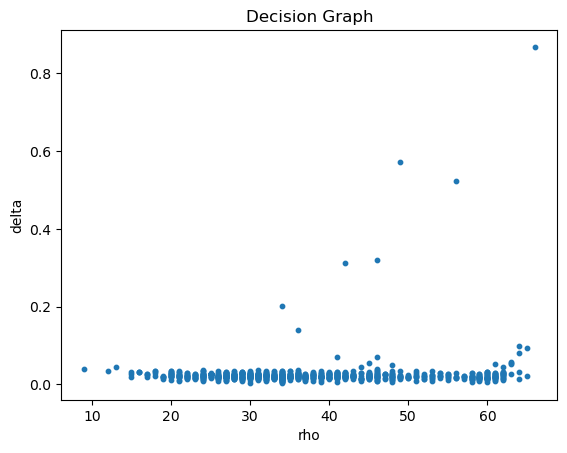

centers:[ 49 189 393 524 614 723 757]


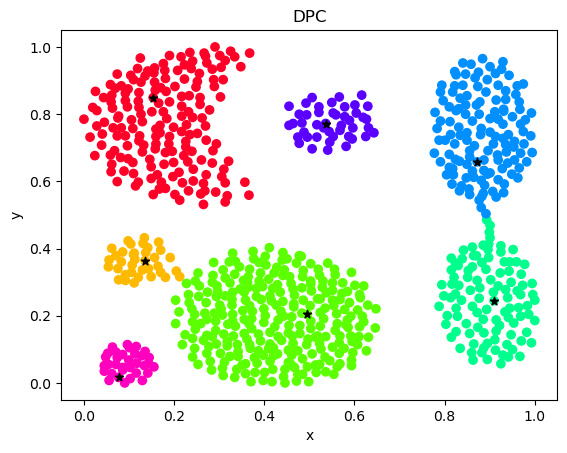

DBI:0.5461


In [18]:
model0 = DPC(0.10)
model0.fit(array[0])
model0.predict(array[0], 30, 0.1)
print('DBI:{:.4f}'.format(davies_bouldin_score(array[0], model0.label)))

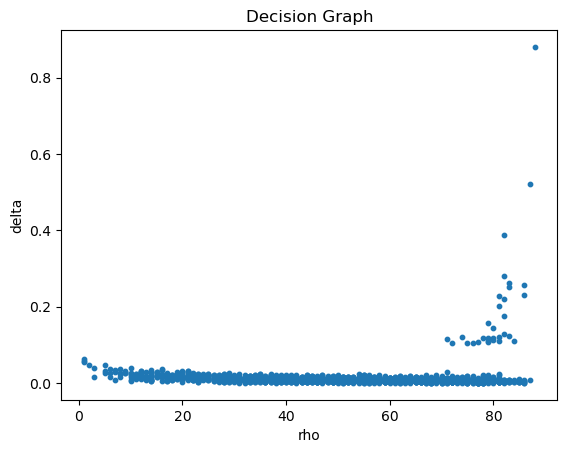

centers:[  74  113  215  318  433  512  668  705  810  957 1024 1173 1234 1352
 1470 1568 1677 1775 1804 1933 2066 2107 2240 2324 2411 2530 2686 2773
 2804 2925 3053]


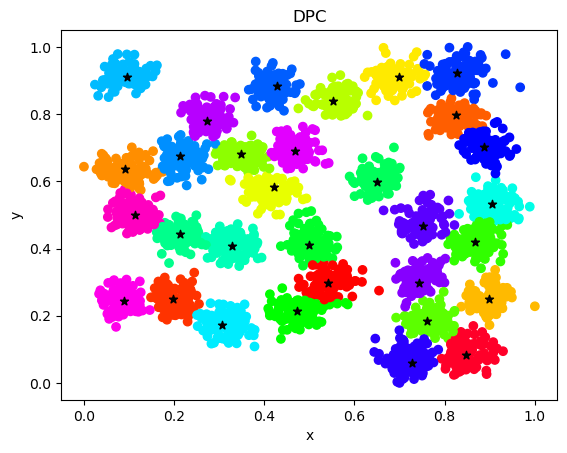

DBI:0.5524


In [19]:
model1 = DPC(0.05)
model1.fit(array[1])
model1.predict(array[1], 60, 0.1)
print('DBI:{:.4f}'.format(davies_bouldin_score(array[1], model1.label)))

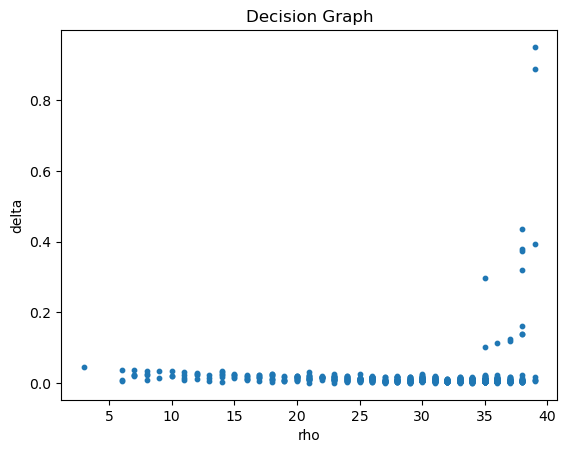

centers:[ 30  40  80 134 170 210 275 299 324 368 404 465 492 543 568]


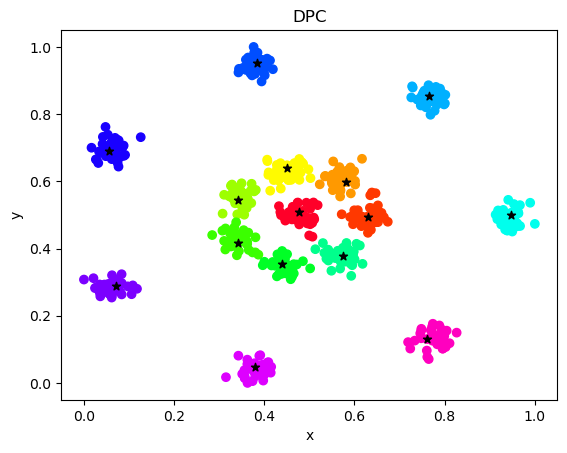

DBI:0.3147


In [20]:
model2 = DPC(0.05)
model2.fit(array[2])
model2.predict(array[2], 30, 0.1)
print('DBI:{:.4f}'.format(davies_bouldin_score(array[2], model2.label)))

## Reference

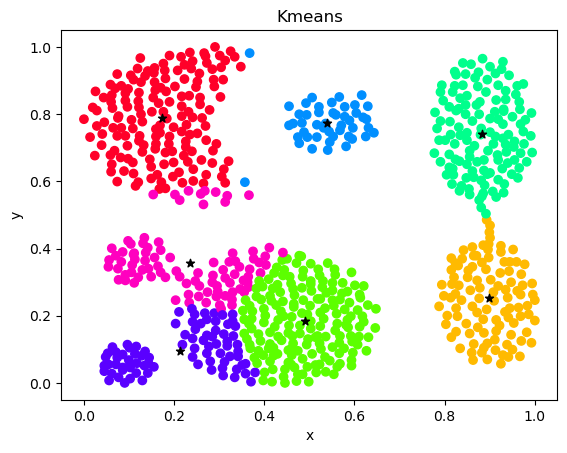

DBI:0.7010


In [21]:
from sklearn.cluster import KMeans
# KMeans聚类
model = KMeans(n_clusters=7)
y_pred = model.fit_predict(array[0])

# 画图显示样本数据
plt.figure('Kmeans')
plt.title('Kmeans')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(array[0][:, 0], array[0][:, 1], c=y_pred, cmap="gist_rainbow")
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c='black', marker='*')
plt.show()
print('DBI:{:.4f}'.format(davies_bouldin_score(array[0], y_pred)))

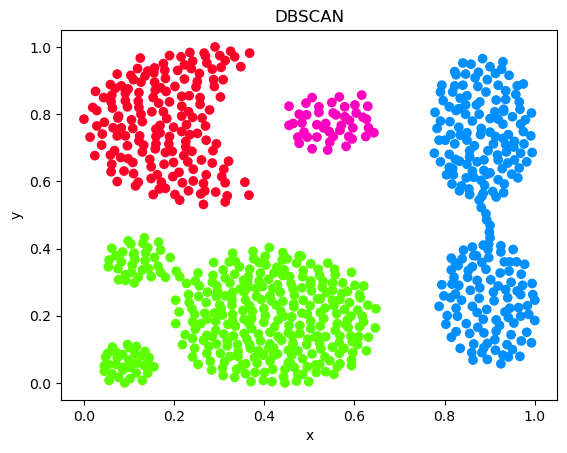

DBI:0.6828


In [22]:
from sklearn.cluster import DBSCAN
# DBSCAN聚类
model = DBSCAN(eps=0.1, min_samples=5)
y_pred = model.fit_predict(array[0])

# 画图显示样本数据
plt.figure('DBSCAN')
plt.title('DBSCAN')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(array[0][:, 0], array[0][:, 1], c=y_pred, cmap="gist_rainbow")
plt.show()
print('DBI:{:.4f}'.format(davies_bouldin_score(array[0], y_pred)))

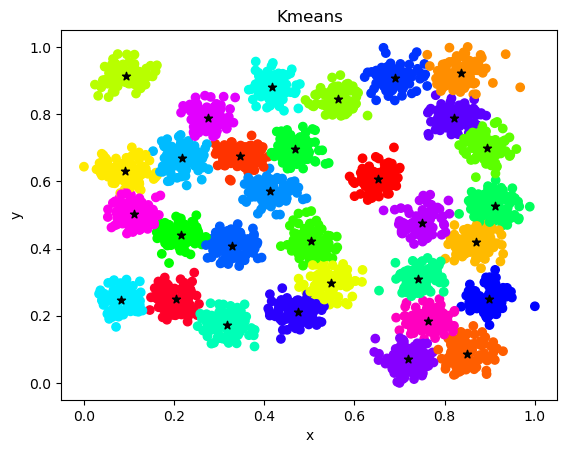

DBI:0.5472


In [23]:
from sklearn.cluster import KMeans
# KMeans聚类
model = KMeans(n_clusters=31)
y_pred = model.fit_predict(array[1])

# 画图显示样本数据
plt.figure('Kmeans')
plt.title('Kmeans')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(array[1][:, 0], array[1][:, 1], c=y_pred, cmap="gist_rainbow")
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c='black', marker='*')
plt.show()
print('DBI:{:.4f}'.format(davies_bouldin_score(array[1], y_pred)))

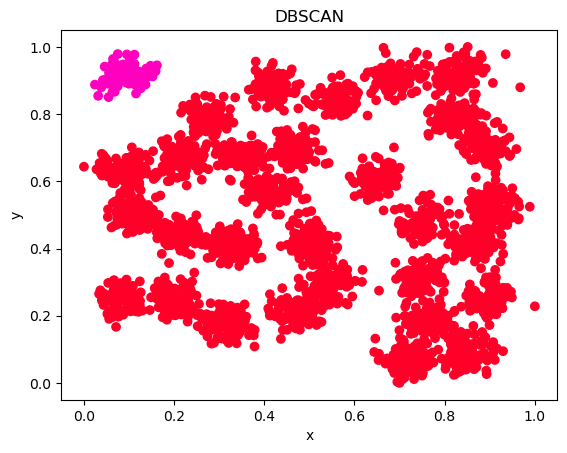

DBI:0.6332


In [24]:
from sklearn.cluster import DBSCAN
# DBSCAN聚类
model = DBSCAN(eps=0.1, min_samples=5)
y_pred = model.fit_predict(array[1])

# 画图显示样本数据
plt.figure('DBSCAN')
plt.title('DBSCAN')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(array[1][:, 0], array[1][:, 1], c=y_pred, cmap="gist_rainbow")
plt.show()
print('DBI:{:.4f}'.format(davies_bouldin_score(array[1], y_pred)))

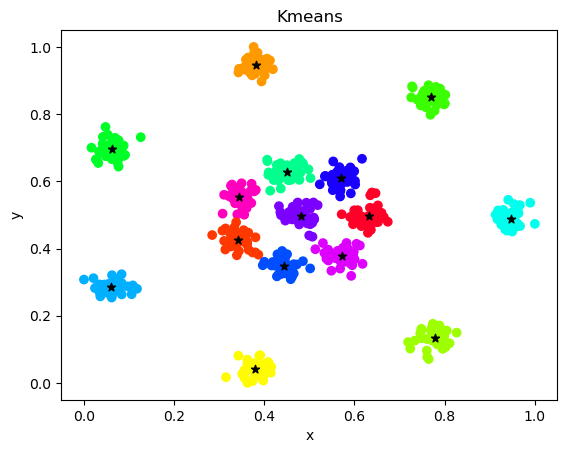

DBI:0.3147


In [25]:
from sklearn.cluster import KMeans
# KMeans聚类
model = KMeans(n_clusters=15)
y_pred = model.fit_predict(array[2])

# 画图显示样本数据
plt.figure('Kmeans')
plt.title('Kmeans')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(array[2][:, 0], array[2][:, 1], c=y_pred, cmap="gist_rainbow")
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c='black', marker='*')
plt.show()
print('DBI:{:.4f}'.format(davies_bouldin_score(array[2], y_pred)))

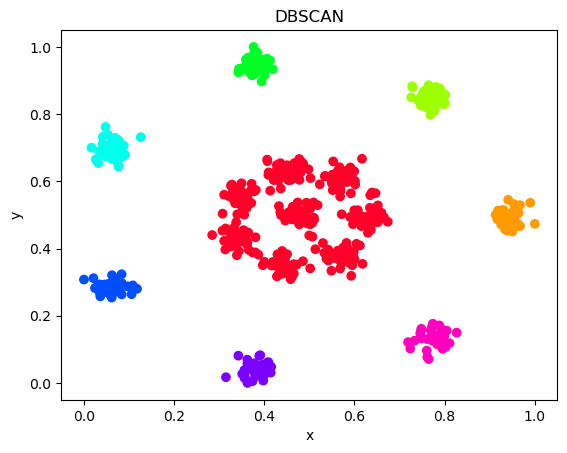

DBI:0.3488


In [26]:
from sklearn.cluster import DBSCAN
# DBSCAN聚类
model = DBSCAN(eps=0.1, min_samples=5)
y_pred = model.fit_predict(array[2])

# 画图显示样本数据
plt.figure('DBSCAN')
plt.title('DBSCAN')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(array[2][:, 0], array[2][:, 1], c=y_pred, cmap="gist_rainbow")
plt.show()
print('DBI:{:.4f}'.format(davies_bouldin_score(array[2], y_pred)))